# **Tarea #2** 
## By: Cristian Alape 20251595001 y Alvaro Zarabanda 20251595006

In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, recall_score, classification_report, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
    'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(url, header=None, names=columns, na_values='?', skipinitialspace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1. Limpieza y EDA (Q1 y Q2)

In [3]:
# Limpieza de datos
print('Valores nulos por columna:')
print(df.isnull().sum())
# Eliminar filas con valores nulos
df_clean = df.dropna()
print(f'Shape después de eliminar nulos: {df_clean.shape}')
# Eliminar duplicados si existen
df_clean = df_clean.drop_duplicates()
print(f'Shape después de eliminar duplicados: {df_clean.shape}')
# Revisar tipos de datos
print(df_clean.dtypes)

Valores nulos por columna:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64
Shape después de eliminar nulos: (30162, 15)
Shape después de eliminar duplicados: (30139, 15)
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


In [4]:
# Porcentaje de valores nulos por columna
print('Porcentaje de valores nulos por columna:')
print((df.isnull().sum() / len(df) * 100).round(2))

Porcentaje de valores nulos por columna:
age               0.00
workclass         5.64
fnlwgt            0.00
education         0.00
education-num     0.00
marital-status    0.00
occupation        5.66
relationship      0.00
race              0.00
sex               0.00
capital-gain      0.00
capital-loss      0.00
hours-per-week    0.00
native-country    1.79
income            0.00
dtype: float64


### Análisis y limpieza de datos

In [5]:
# 2. Visualización de la forma del dataset
print('Forma del dataset (filas, columnas):', df_clean.shape)

Forma del dataset (filas, columnas): (30139, 15)


### Forma del dataset

In [6]:
# 3. Análisis de los tipos de datos de cada columna
print('Tipos de datos por columna:')
print(df_clean.dtypes)

Tipos de datos por columna:
age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object


### Tipos de datos por columna
El análisis de los tipos de datos permite identificar qué variables son numéricas y cuáles son categóricas. Esto es fundamental para seleccionar las técnicas de preprocesamiento y análisis adecuadas. Las variables numéricas pueden ser usadas directamente en modelos matemáticos, mientras que las categóricas suelen requerir codificación especial (por ejemplo, one-hot encoding).

In [7]:
# 4. Estadísticas descriptivas para variables numéricas
print('Estadísticas descriptivas:')
print(df_clean.describe().T[['mean','std','min','max']])

Estadísticas descriptivas:
                         mean            std      min        max
age                 38.441720      13.131426     17.0       90.0
fnlwgt          189795.025980  105658.624341  13769.0  1484705.0
education-num       10.122532       2.548738      1.0       16.0
capital-gain      1092.841202    7409.110596      0.0    99999.0
capital-loss        88.439928     404.445239      0.0     4356.0
hours-per-week      40.934703      11.978753      1.0       99.0


### Analisis de estadísticas descriptivas
Las estadísticas descriptivas (media, desviación estándar, mínimo, máximo) permiten entender la tendencia central y la dispersión de las variables numéricas. Esto ayuda a identificar posibles valores atípicos, rangos de variación y la escala de cada variable, lo cual es útil para la normalización y el modelado posterior.

#### Matriz de gráficos de dispersión (pairplot)
El pairplot permite observar las relaciones bivariadas entre todas las variables numéricas y cómo se distribuyen según la variable objetivo ('income'). Se pueden identificar patrones, agrupamientos y posibles correlaciones entre variables. Por ejemplo, se observa que los ingresos altos tienden a agruparse en ciertos rangos de edad, nivel educativo y horas trabajadas. Además, la visualización ayuda a detectar outliers y relaciones no lineales que podrían ser relevantes para el modelado.

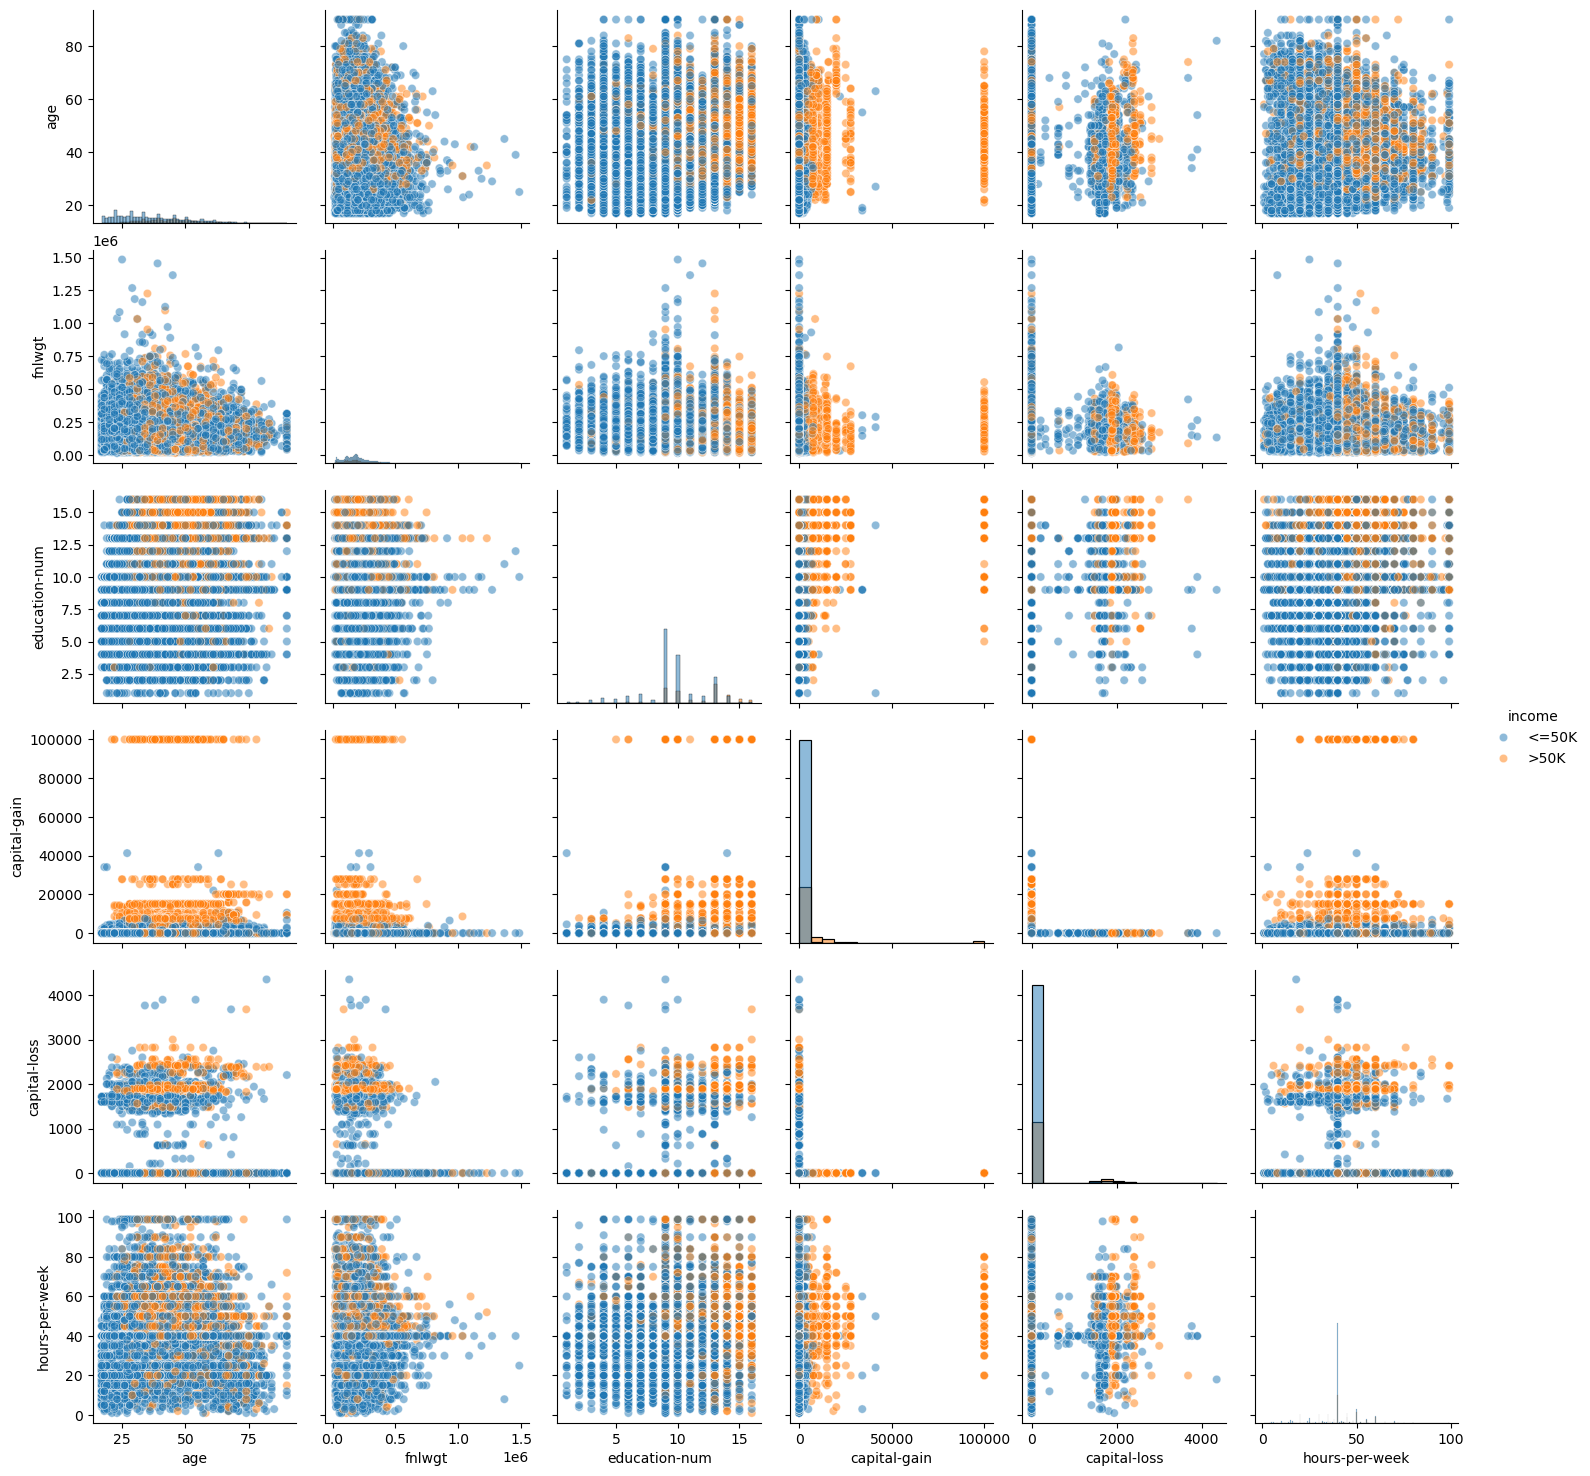

In [8]:
# Matriz de gráficos de dispersión entre variables numéricas
sns.pairplot(df_clean, vars=['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'], hue='income', diag_kind='hist', plot_kws={'alpha':0.5})
plt.show()

##### Análisis detallado del pairplot de variables numéricas
El pairplot generado permite observar simultáneamente las relaciones bivariadas entre todas las variables numéricas del dataset, diferenciando los grupos de ingreso ('>50K' y '<=50K') mediante el color. A continuación se detallan los principales hallazgos:
- **Distribución de cada variable:** En los histogramas de la diagonal se observa que variables como 'capital-gain' y 'capital-loss' presentan una fuerte asimetría, con la mayoría de los valores en cero y pocos valores extremos. 'Age' y 'hours-per-week' muestran distribuciones más uniformes, aunque con presencia de outliers.
- **Relaciones entre variables:** La dispersión entre 'age' y 'education-num' sugiere que las personas de mayor edad tienden a tener mayor nivel educativo, aunque no es una relación estrictamente lineal. Entre 'hours-per-week' y 'capital-gain' se observa que quienes trabajan más horas pueden tener mayores ganancias de capital, pero la mayoría de los individuos no reporta ganancias significativas.
- **Separación de clases:** Los puntos correspondientes a ingresos '>50K' tienden a agruparse en rangos más altos de edad, nivel educativo y horas trabajadas. Sin embargo, existe superposición entre los grupos, lo que indica que no hay una frontera clara y que el problema de clasificación es complejo.
- **Outliers y valores extremos:** El pairplot facilita la identificación visual de outliers, especialmente en 'fnlwgt', 'capital-gain' y 'capital-loss'. Estos valores pueden influir negativamente en el modelado y podrían requerir tratamiento especial.
- **Correlaciones débiles:** La mayoría de las relaciones entre variables numéricas no muestra una correlación fuerte, lo que sugiere que cada variable aporta información complementaria para la predicción del ingreso.
- **Implicaciones para el modelado:** La superposición de clases y la presencia de outliers indican que será necesario aplicar técnicas de preprocesamiento adicionales (como escalado, transformación o manejo de outliers) y considerar modelos robustos. Además, la baja correlación entre variables sugiere que el uso conjunto de todas ellas puede mejorar la capacidad predictiva del modelo.
El pairplot es una herramienta poderosa para explorar la estructura interna del dataset, identificar patrones relevantes y anticipar desafíos en el modelado predictivo.

### Histogramas y Boxplots

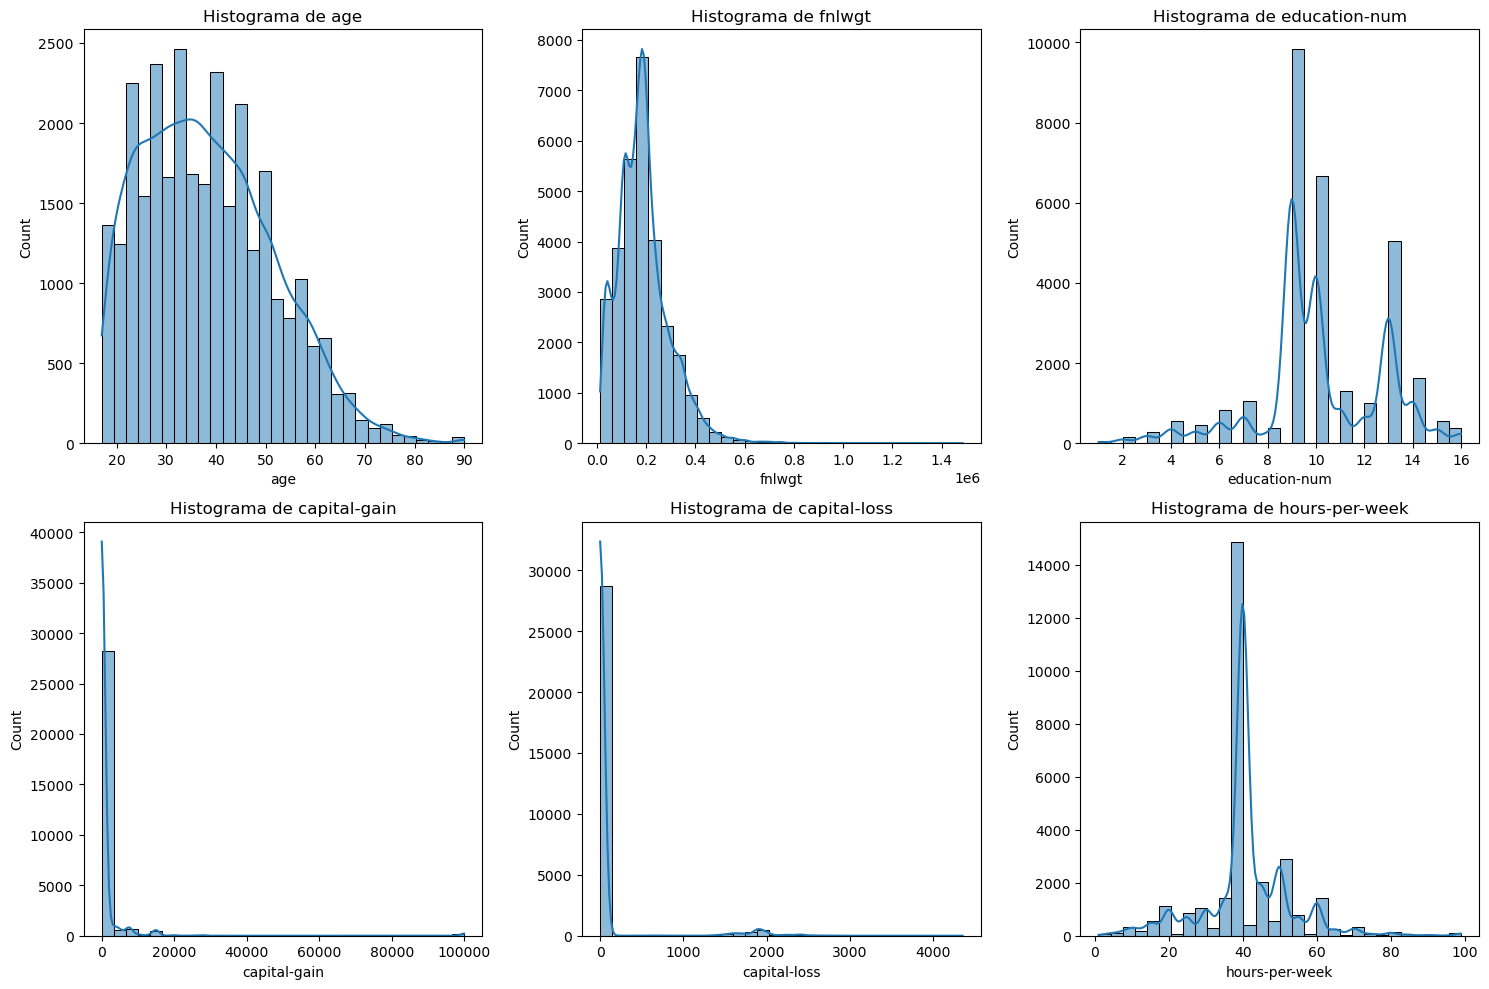

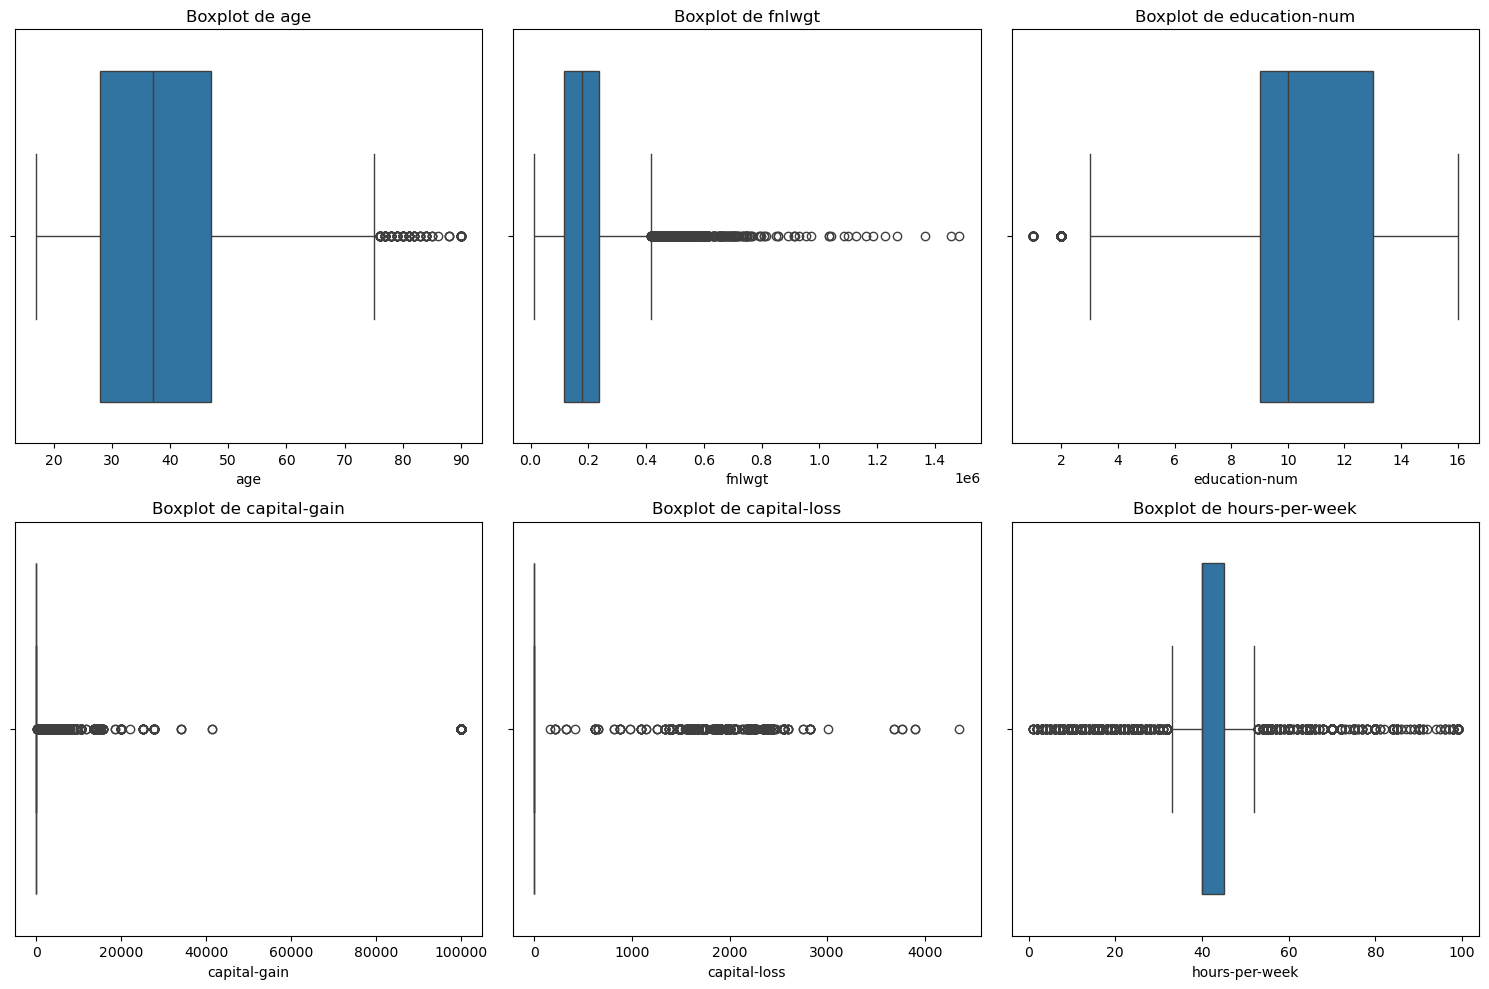

In [9]:
# 5. Visualización de la distribución de variables numéricas y outliers
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    sns.histplot(df_clean[col].dropna(), bins=30, kde=True)
    plt.title(f'Histograma de {col}')
plt.tight_layout()
plt.show()
plt.figure(figsize=(15,10))
for i, col in enumerate(num_cols):
    plt.subplot(2,3,i+1)
    sns.boxplot(x=df_clean[col].dropna())
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

#### Interpretación: Histogramas y Boxplots de variables numéricas
Los histogramas muestran que la mayoría de las variables numéricas tienen distribuciones sesgadas, especialmente 'capital-gain' y 'capital-loss', donde la mayoría de los valores son cero y existen pocos valores extremos. 'Age' y 'hours-per-week' presentan distribuciones más uniformes, aunque con algunos outliers identificados en los boxplots. Estos outliers pueden influir en el análisis y deben considerarse en el preprocesamiento. La variable 'fnlwgt' muestra una amplia dispersión, lo que sugiere que representa un factor de ponderación más que una característica directa del individuo.

Conteo de valores de income:
income
<=50K    22633
>50K      7506
Name: count, dtype: int64


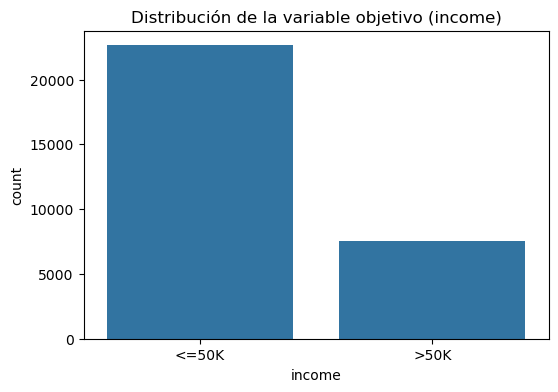

In [10]:
# 6. Análisis de la variable objetivo ('income') y su distribución
print('Conteo de valores de income:')
print(df_clean['income'].value_counts())
plt.figure(figsize=(6,4))
sns.countplot(x='income', data=df_clean)
plt.title('Distribución de la variable objetivo (income)')
plt.show()

### Análisis de variable objetivo
La variable 'income' representa el objetivo de predicción: si el ingreso anual de una persona es mayor o menor a 50K. Analizar su distribución permite identificar posibles desbalances de clases, lo cual es importante para seleccionar métricas de evaluación y técnicas de muestreo en el modelado. Un dataset balanceado facilita el entrenamiento de modelos más precisos y justos.

### Definición de la variable objetivo
La variable objetivo en este análisis es 'income', que indica si el ingreso anual de una persona es '>50K' (mayor a 50 mil dólares) o '<=50K' (menor o igual a 50 mil dólares). Esta variable será utilizada para entrenar modelos de clasificación que predigan el nivel de ingresos a partir de las demás características del dataset.

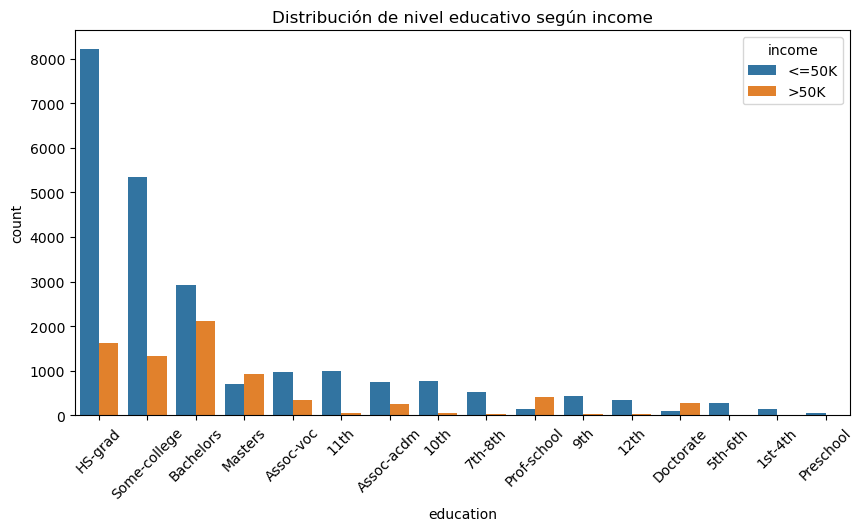

In [11]:
# Visualización: distribución de 'education' según 'income'
plt.figure(figsize=(10,5))
sns.countplot(x='education', hue='income', data=df_clean, order=df_clean['education'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribución de nivel educativo según income')
plt.show()

#### Interpretación: Educación vs Income
Se observa que los niveles educativos más altos, como 'Bachelors', 'Masters' y 'Doctorate', tienen una mayor proporción de personas con ingresos superiores a 50K. En cambio, niveles como 'HS-grad' y 'Some-college' presentan una mayor proporción de ingresos bajos. Esto sugiere una relación positiva entre el nivel educativo y el ingreso.

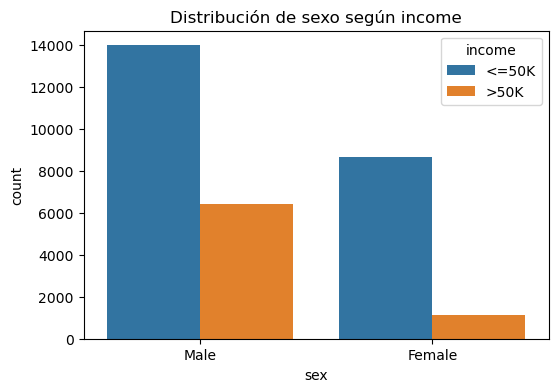

In [12]:
# Visualización: distribución de 'sex' según 'income'
plt.figure(figsize=(6,4))
sns.countplot(x='sex', hue='income', data=df_clean)
plt.title('Distribución de sexo según income')
plt.show()

#### Interpretación: Sexo vs Income
El gráfico muestra que los hombres tienen una mayor proporción de ingresos superiores a 50K en comparación con las mujeres. Esto puede reflejar desigualdades de género en el mercado laboral y en el acceso a empleos mejor remunerados.

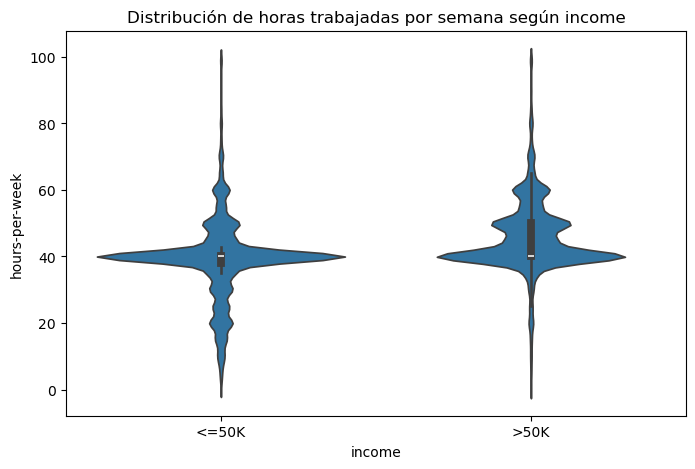

In [13]:
# Visualización: horas trabajadas por semana vs. ingreso
plt.figure(figsize=(8,5))
sns.violinplot(x='income', y='hours-per-week', data=df_clean)
plt.title('Distribución de horas trabajadas por semana según income')
plt.show()

#### Interpretación: Horas trabajadas por semana vs Income
Las personas con ingresos superiores a 50K tienden a trabajar más horas por semana, aunque existe una superposición considerable entre ambos grupos. Esto indica que trabajar más horas puede estar asociado a mayores ingresos, pero no es el único factor determinante.

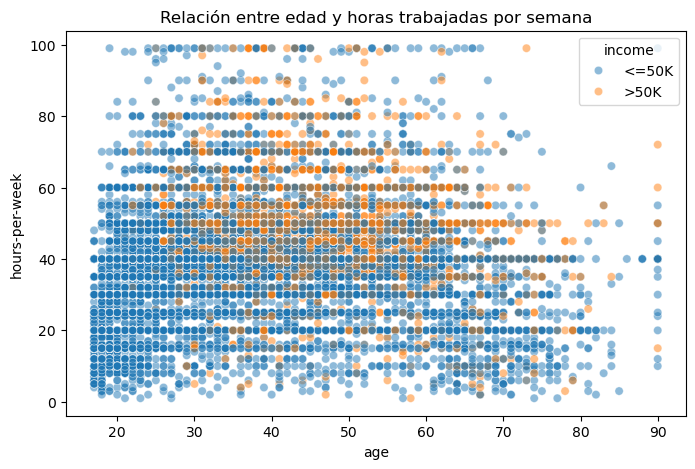

In [14]:
# Visualización: relación entre edad y horas trabajadas
plt.figure(figsize=(8,5))
sns.scatterplot(x='age', y='hours-per-week', hue='income', data=df_clean, alpha=0.5)
plt.title('Relación entre edad y horas trabajadas por semana')
plt.show()

#### Interpretación: Edad vs Horas trabajadas
No se observa una relación clara entre la edad y las horas trabajadas por semana. Sin embargo, la mayoría de los ingresos altos se concentran en personas de mediana edad, lo que podría indicar que la experiencia laboral influye en el nivel de ingresos.

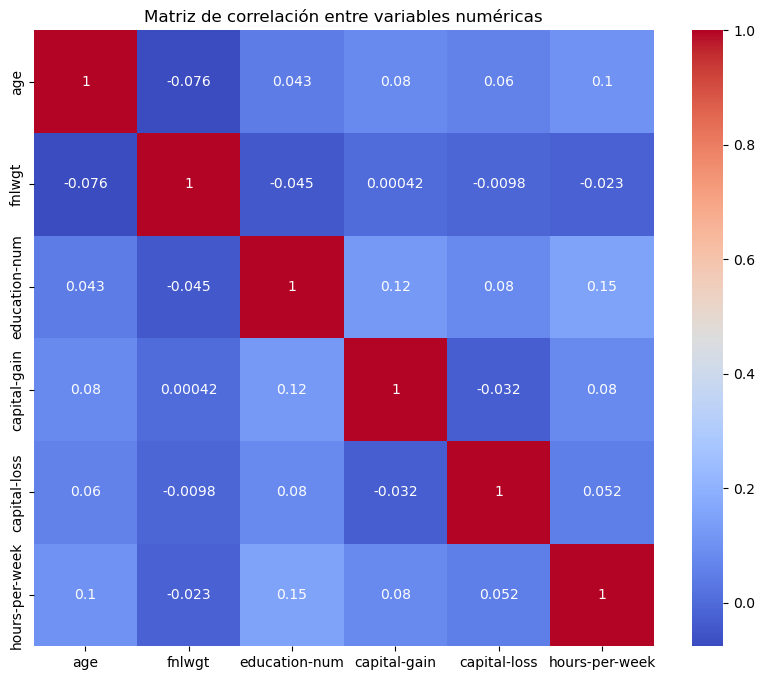

In [15]:
# Matriz de correlación entre variables numéricas
plt.figure(figsize=(10,8))
corr = df_clean[['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

#### Interpretación: Matriz de correlación
Las correlaciones más altas se observan entre 'education-num' y 'age', lo que puede indicar que las personas mayores tienden a tener mayor nivel educativo. Sin embargo, la mayoría de las variables numéricas no presentan correlaciones fuertes entre sí, lo que sugiere que aportan información complementaria para el análisis y modelado.

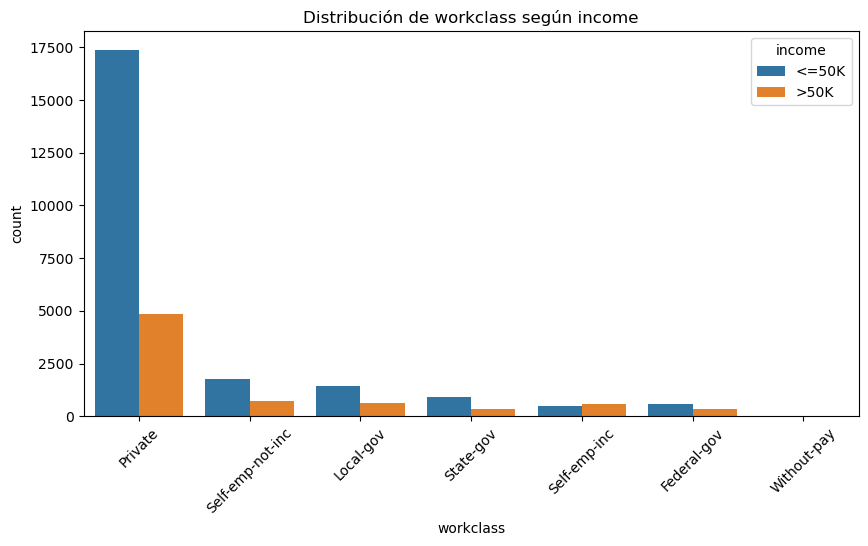

In [16]:
# Visualización: distribución de 'workclass' según 'income'
plt.figure(figsize=(10,5))
sns.countplot(x='workclass', hue='income', data=df_clean, order=df_clean['workclass'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribución de workclass según income')
plt.show()

#### Interpretación: Workclass vs Income
Se observa que las personas que trabajan en el sector privado ('Private') son mayoría en ambos grupos de ingreso, pero la proporción de ingresos altos es mayor en categorías como 'Self-emp-not-inc' y 'Federal-gov'. Esto sugiere que el tipo de trabajo influye en el nivel de ingresos.

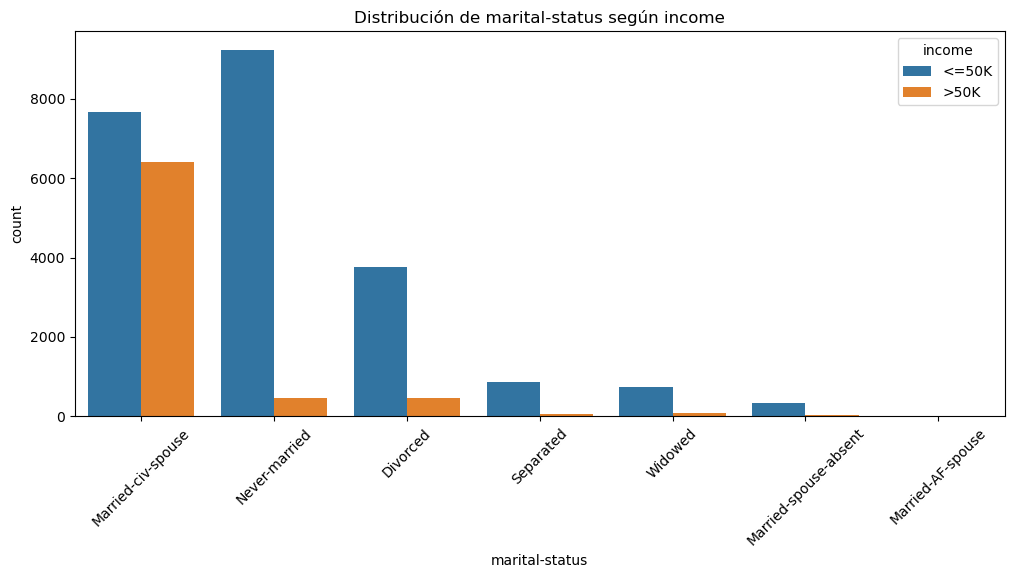

In [17]:
# Visualización: distribución de 'marital-status' según 'income'
plt.figure(figsize=(12,5))
sns.countplot(x='marital-status', hue='income', data=df_clean, order=df_clean['marital-status'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribución de marital-status según income')
plt.show()

#### Interpretación: Marital-status vs Income
Las personas casadas ('Married-civ-spouse') presentan una mayor proporción de ingresos altos, mientras que los grupos 'Never-married' y 'Divorced' tienen mayor proporción de ingresos bajos. El estado civil parece estar relacionado con el nivel de ingresos, posiblemente por factores como estabilidad laboral o doble ingreso familiar.

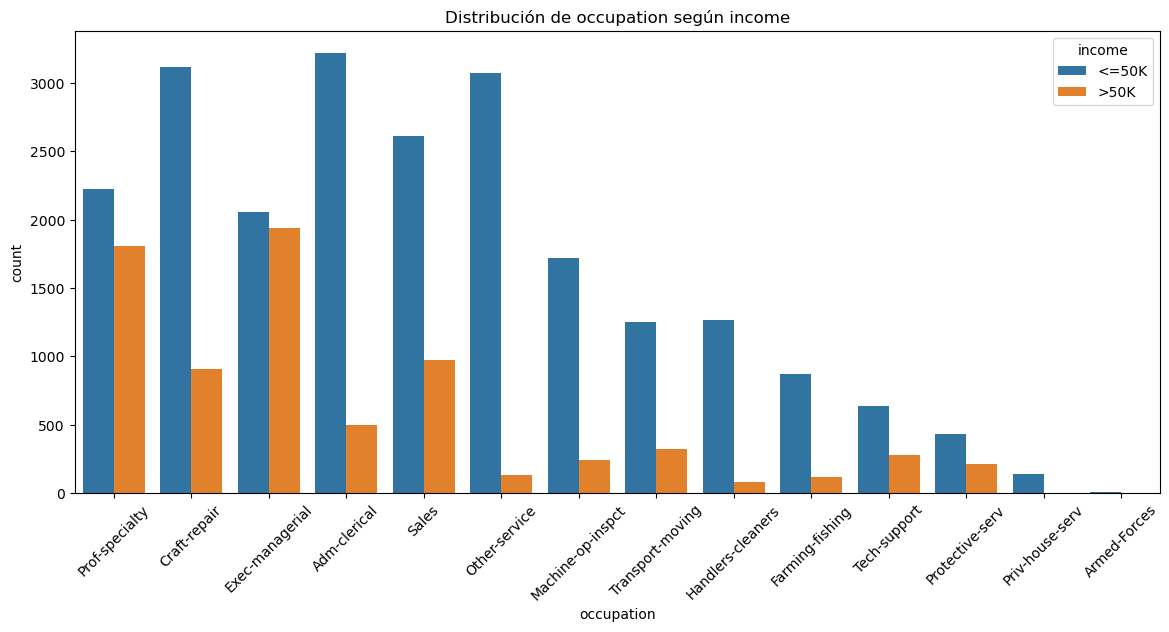

In [18]:
# Visualización: distribución de 'occupation' según 'income'
plt.figure(figsize=(14,6))
sns.countplot(x='occupation', hue='income', data=df_clean, order=df_clean['occupation'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribución de occupation según income')
plt.show()

#### Interpretación: Occupation vs Income
Algunas ocupaciones como 'Exec-managerial' y 'Prof-specialty' tienen una mayor proporción de ingresos altos, mientras que ocupaciones como 'Handlers-cleaners' y 'Other-service' predominan en el grupo de ingresos bajos. Esto evidencia la influencia del tipo de ocupación en el nivel de ingresos.

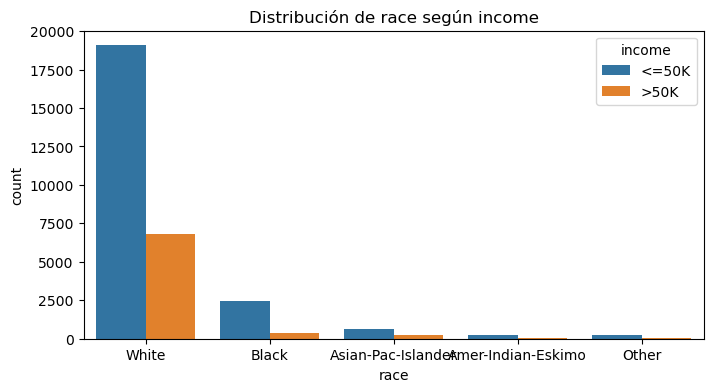

In [19]:
# Visualización: distribución de 'race' según 'income'
plt.figure(figsize=(8,4))
sns.countplot(x='race', hue='income', data=df_clean, order=df_clean['race'].value_counts().index)
plt.title('Distribución de race según income')
plt.show()

#### Interpretación: Race vs Income
La mayoría de los ingresos altos se concentran en el grupo 'White', mientras que otros grupos raciales presentan una mayor proporción de ingresos bajos. Esto puede reflejar desigualdades estructurales y sociales en el acceso a oportunidades laborales y educativas.

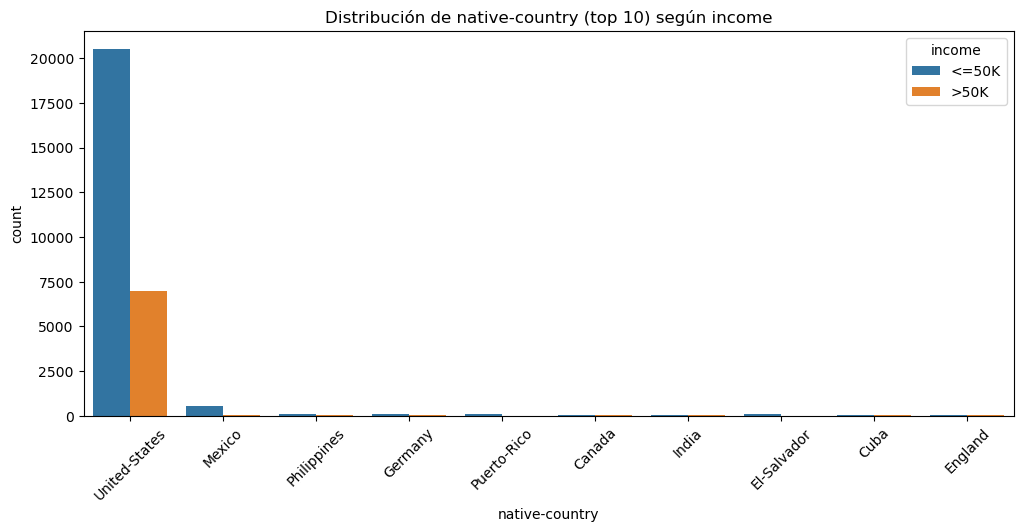

In [20]:
# Visualización: distribución de 'native-country' según 'income' (solo los 10 países más frecuentes)
top_countries = df_clean['native-country'].value_counts().index[:10]
plt.figure(figsize=(12,5))
sns.countplot(x='native-country', hue='income', data=df_clean[df_clean['native-country'].isin(top_countries)], order=top_countries)
plt.xticks(rotation=45)
plt.title('Distribución de native-country (top 10) según income')
plt.show()

#### Interpretación: Native-country vs Income
La mayoría de los ingresos altos se concentran en personas nacidas en Estados Unidos. Otros países presentan una mayor proporción de ingresos bajos, lo que puede estar relacionado con factores migratorios, acceso a oportunidades y barreras socioeconómicas.

## 2. División de datos en entrenamiento y prueba (Q3)
En esta sección se realiza la división del dataset en conjuntos de entrenamiento y prueba, lo cual es fundamental para evaluar el desempeño de los modelos de predicción de manera objetiva. El conjunto de entrenamiento se utiliza para ajustar el modelo, mientras que el conjunto de prueba permite medir su capacidad de generalización sobre datos no vistos.

Esta division de datos se hara dependeiendo del algoritmo, ya que las caracteristicas a incluir dependen de dicho algoritmo. 

In [21]:
# División de datos en entrenamiento y prueba
X = df_clean.drop('income', axis=1)
y = df_clean['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Forma de X_train:', X_train.shape)
print('Forma de X_test:', X_test.shape)
print('Distribución de la variable objetivo en el conjunto de entrenamiento:')
print(y_train.value_counts(normalize=True).round(3))
print('Distribución de la variable objetivo en el conjunto de prueba:')
print(y_test.value_counts(normalize=True).round(3))

Forma de X_train: (24111, 14)
Forma de X_test: (6028, 14)
Distribución de la variable objetivo en el conjunto de entrenamiento:
income
<=50K    0.751
>50K     0.249
Name: proportion, dtype: float64
Distribución de la variable objetivo en el conjunto de prueba:
income
<=50K    0.751
>50K     0.249
Name: proportion, dtype: float64


## Variables prometedoras (q4)

Se seleccionaron 3 variables para mejor legibilidad en los plots permitiendo ver regiones de decisión claras, tecnicamente mejora la interpretabilidad sin perdida de rendimiento, es logico, la edad , el capital y la educación son caractecteristicas demaciado fuertes al ser variables de caracterizacion socio demografica 


In [22]:
#q4.2
# Calcular MI con dummies pero mapear al nombre original

# 2) Seleccionar Top-3 NUMÉRICAS por mutual information (para trazar regiones 2D continuas)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
mi = mutual_info_classif(X_train[numeric_cols], y_train, random_state=42)
feat_imp = pd.Series(mi, index=numeric_cols).sort_values(ascending=False)
top3 = feat_imp.head(3).index.tolist()

print("Top-3 numéricas (por mutual information):", top3)
pares = [(top3[0], top3[1]), (top3[0], top3[2]), (top3[1], top3[2])]


Top-3 numéricas (por mutual information): ['capital-gain', 'age', 'education-num']


Para cada par, se entrena un clasificador de reglas (mini árbol de decisión poco profundo) con cada par de predictores como se puede ver en los parametros, ademas se usa la metrica de f1 score para evaluar su rendimiento, se implementan reglas para cada mini arbol, se hacen los respectivos entrenamientos con el metodo fit, el f1 se define para la variable positiva, se busca encontrar qué tan bien el modelo balancea precisión y recall


In [23]:
from sklearn.tree import DecisionTreeClassifier, export_text
modelos, pesos = {}, {}
for (c1, c2) in pares:
    Xtr = X_train[[c1, c2]]
    Xte = X_test[[c1, c2]]

    clf = DecisionTreeClassifier(
        criterion="gini",
        max_depth=3,            # interpretable
        min_samples_leaf=50,    # evita hojas diminutas
        random_state=42
    )
    clf.fit(Xtr, y_train)      # y_train = strings
    y_pred = clf.predict(Xte)  # y_pred = strings
    y_pred_modelo_1 = y_pred
    y_pred_modelo_1_proba = clf.predict_proba(Xte)  # y_pred = strings

    f1 = f1_score(y_test, y_pred, pos_label='>50K')  # <<< pos_label string
    modelos[(c1, c2)] = clf
    pesos[(c1, c2)] = f1

    print(f"\n=== Par: ({c1}, {c2}) | F1={f1:.3f} ===")
    print("Reglas IF–THEN (export_text):")
    print(export_text(clf, feature_names=[c1, c2]))


=== Par: (capital-gain, age) | F1=0.322 ===
Reglas IF–THEN (export_text):
|--- capital-gain <= 5119.00
|   |--- age <= 29.50
|   |   |--- age <= 25.50
|   |   |   |--- class: <=50K
|   |   |--- age >  25.50
|   |   |   |--- class: <=50K
|   |--- age >  29.50
|   |   |--- age <= 36.50
|   |   |   |--- class: <=50K
|   |   |--- age >  36.50
|   |   |   |--- class: <=50K
|--- capital-gain >  5119.00
|   |--- capital-gain <= 7073.50
|   |   |--- capital-gain <= 5316.50
|   |   |   |--- class: >50K
|   |   |--- capital-gain >  5316.50
|   |   |   |--- class: <=50K
|   |--- capital-gain >  7073.50
|   |   |--- age <= 60.50
|   |   |   |--- class: >50K
|   |   |--- age >  60.50
|   |   |   |--- class: >50K


=== Par: (capital-gain, education-num) | F1=0.476 ===
Reglas IF–THEN (export_text):
|--- capital-gain <= 5119.00
|   |--- education-num <= 12.50
|   |   |--- education-num <= 8.50
|   |   |   |--- class: <=50K
|   |   |--- education-num >  8.50
|   |   |   |--- class: <=50K
|   |--- educ

este bloque muestra las predicciones de los tres clasificadores por pares en una decisión final usando un esquema de voto ponderado. Es decir:

- Cada clasificador por par hace una predicción (">50K" o "< =50K").
- Esa predicción se traduce en un voto: +1 si es ">50K", -1 si es "< =50K".
- Ese voto se multiplica por el peso del modelo (su F1-score, calculado antes).
- Finalmente, se suman los votos ponderados de todos los clasificadores.
- Si el total es positivo → predicción final ">50K".
- Si el total es negativo o cero → predicción final "< =50K".

In [24]:
def ensamble_pred(X):
    # votos > 0 => '>50K', si no '<=50K'
    votos = np.zeros(len(X), dtype=float)
    for (c1, c2), clf in modelos.items():
        pred = clf.predict(X[[c1, c2]])  # strings
        # +peso si '>50K', -peso si '<=50K'
        votos += np.where(pred == '>50K', 1.0, -1.0) * pesos[(c1, c2)]
    return np.where(votos > 0, '>50K', '<=50K')

y_ens = ensamble_pred(X_test)
print("\n== Ensamble (3 pares) ==")
print("F1:", f1_score(y_test, y_ens, pos_label='>50K'))
print("Reporte:\n", classification_report(y_test, y_ens))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_ens, labels=['<=50K','>50K']))



== Ensamble (3 pares) ==
F1: 0.47938377888536476
Reporte:
               precision    recall  f1-score   support

       <=50K       0.82      0.96      0.88      4527
        >50K       0.75      0.35      0.48      1501

    accuracy                           0.81      6028
   macro avg       0.78      0.66      0.68      6028
weighted avg       0.80      0.81      0.78      6028

Matriz de confusión:
 [[4350  177]
 [ 972  529]]


El F1: 0.47938377888536476 de la clase positiva combina precisión y recall de esa clase, el modelo no está equilibrando bien precisión y recall para detectar ingresos mayores a 50K, se debe a que la clase es minoritaria, el recall detecta correctamente al 96% de las personas con ingresos <=50K.

El Acuracy parece alto, pero está sesgado por la clase mayoritaria (<=50K), ya que la mayoría de ejemplos pertenecen allí. El Promedio ponderado por la cantidad de instancias en cada clase, se acerca a la accuracy (0.78) porque la clase <=50K domina el dataset.

Para la fila 1 <=50K se identificaron 4350 correctamente predichos como <=50K y 177 falsos positivos (predijo >50K cuando en realidad eran <=50K). Para la Fila 2 (real >50K): se identificaron  529 correctamente predichos como >50K y 972 falsos negativos (personas que ganan >50K pero el modelo predijo <=50K).

El problema está en los 972 falsos negativos, el modelo falla mucho en reconocer la clase positiva.

Se dibujan las zonas de decisión 2D de un clasificador entrenado con solo dos variables (un “par”) y superponer puntos reales del conjunto de prueba para ver qué tan bien encajan con esas zonas. El Color del punto corresponde a clase real  no la predicha así se puede comparar zonas del modelo vs casos reales.


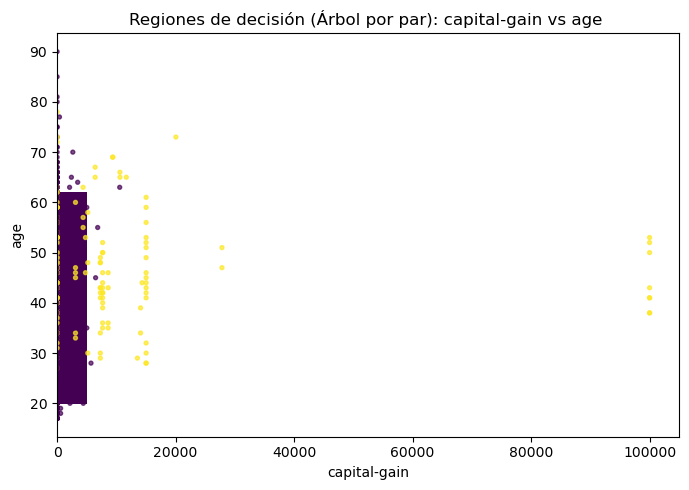

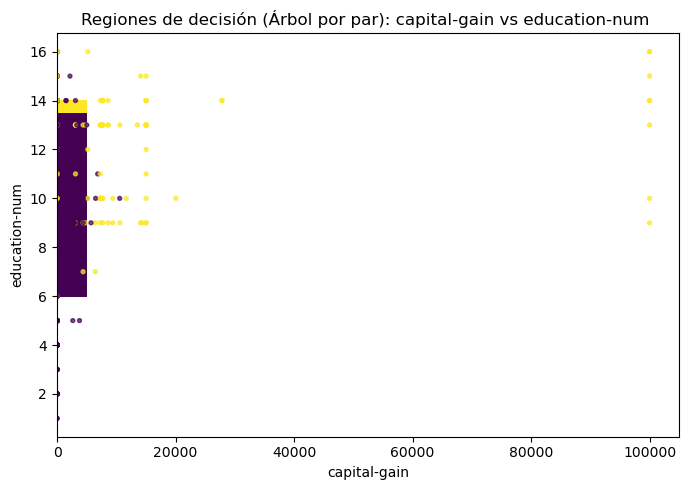

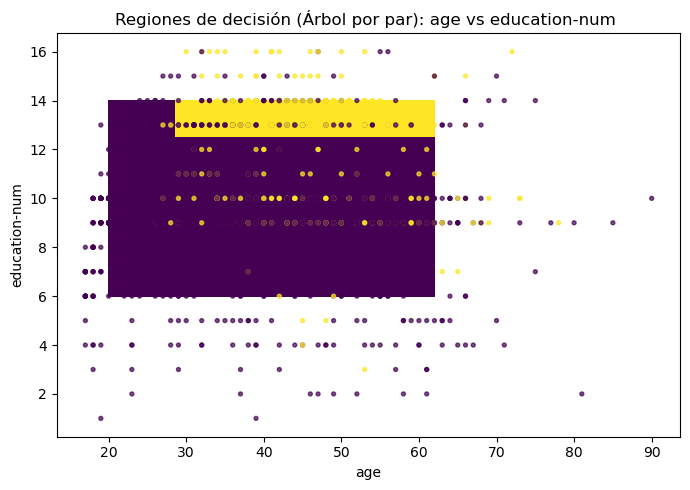

In [25]:
def decision_region_plot(clf, X_train, y_train, X_test, y_test, c1, c2, title_suffix=""):
    # Rango en percentiles (evita outliers extremos)
    x_min, x_max = np.percentile(X_train[c1], [5, 95])
    y_min, y_max = np.percentile(X_train[c2], [5, 95])

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    grid = pd.DataFrame({c1: xx.ravel(), c2: yy.ravel()})
    zz = clf.predict(grid)  # strings
    zz01 = (zz == '>50K').astype(int).reshape(xx.shape)

    plt.figure(figsize=(7,5))
    plt.pcolormesh(xx, yy, zz01, shading='auto')  # regiones 0/1 (colores por defecto)

    # Submuestreo para legibilidad
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X_test), size=min(1500, len(X_test)), replace=False)
    Xs = X_test.iloc[idx][[c1, c2]]
    ys = (y_test.iloc[idx] == '>50K').astype(int)

    plt.scatter(Xs[c1], Xs[c2], c=ys, s=8, alpha=0.7)
    plt.xlabel(c1)
    plt.ylabel(c2)
    plt.title(f"Regiones de decisión (Árbol por par): {c1} vs {c2} {title_suffix}")
    plt.tight_layout()
    plt.show()

for (c1, c2), clf in modelos.items():
    decision_region_plot(clf, X_train, y_train, X_test, y_test, c1, c2)


Para interpretar los diagramas, inicialmente las Zonas coloreadas al fondo Representan la decisión del modelo en cada punto del plano (c1, c2); donde zona A corresponde cuando el modelo diría <=50K y la Zona B cuando el modelo diría >50K.

Los Puntos superpuestos son observaciones reales (del conjunto de test) posicionadas según sus valores en c1 y c2, donde el color del punto indica su clase real, por otro lado, si el color del punto coincide con el color de fondo → el modelo acierta en esa ubicación. Definitivamente si no coincide entonces el error  es falso positivo o falso negativo según el caso.

A pesar de que los resultados no son los mejores, el clasificador con mas rendimiento es el de edad vs nivel educativo.

## 4. Clasificador de arbol de decision  (Q5)

In [26]:
# Label Encoding para todas las variables categóricas
df_encoded = df_clean.copy()
cat_cols = df_encoded.select_dtypes(include=['object']).columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    le_dict[col] = le
df_encoded

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,2,257302,7,12,2,12,5,4,0,0,0,38,38,0
32557,40,2,154374,11,9,2,6,0,4,1,0,0,40,38,1
32558,58,2,151910,11,9,6,0,4,4,0,0,0,40,38,0
32559,22,2,201490,11,9,4,0,3,4,1,0,0,20,38,0


### Variables a usar en el árbol de decisión

En el análisis del dataset, las variables detectadas como relevantes son aquellas que muestran mayor capacidad de separar los grupos de ingreso ('>50K' y '<=50K'). Según el análisis exploratorio y la importancia de las variables, las más relevantes son:

- **education-num**: Representa el nivel educativo de manera ordinal. Se observa que a mayor nivel educativo, hay mayor proporción de ingresos altos. Es una de las variables más predictivas.
- **hours-per-week**: Las personas que trabajan más horas por semana tienden a tener mayores ingresos, aunque existe cierta superposición entre grupos.
- **occupation**: Algunas ocupaciones como 'Exec-managerial' y 'Prof-specialty' concentran una mayor proporción de ingresos altos, mientras que otras predominan en el grupo de ingresos bajos.
- **age**: La edad está asociada a la experiencia laboral y, en muchos casos, a mayores ingresos.
- **capital-gain** y **capital-loss**: Aunque la mayoría de los valores son cero, los valores altos en estas variables suelen estar asociados a ingresos altos.

**Justificación:**
Estas variables destacan en los análisis gráficos (pairplot, histogramas, gráficos de barras) y en la interpretación de la matriz de correlación. Además, suelen aparecer como las más importantes al analizar la importancia de las variables en el modelo de árbol de decisión. Incluir estas variables permite al modelo captar información clave sobre educación, esfuerzo laboral, tipo de trabajo y factores económicos, mejorando así la capacidad predictiva del árbol de decisión.

In [27]:
# Se eliminan columnas que no se incluiran en el modelo segun el analisis
df_tree_model = df_encoded.drop(columns=['workclass', 'fnlwgt', 'education', 'marital-status', 'relationship', 'race', 'sex', 'native-country'])

In [28]:
df_tree_model

,age,education-num,occupation,capital-gain,capital-loss,hours-per-week,income
0,39,13,0,2174,0,40,0
1,50,13,3,0,0,13,0
2,38,9,5,0,0,40,0
3,53,7,5,0,0,40,0
4,28,13,9,0,0,40,0
...,...,...,...,...,...,...,...
32556,27,12,12,0,0,38,0
32557,40,9,6,0,0,40,1
32558,58,9,0,0,0,40,0
32559,22,9,0,0,0,20,0


In [29]:
X = df_tree_model.drop('income', axis=1)
y = df_tree_model['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Forma de X_train:', X_train.shape)
print('Forma de X_test:', X_test.shape)
print('Distribución de la variable objetivo en el conjunto de entrenamiento:')
print(y_train.value_counts(normalize=True).round(3))
print('Distribución de la variable objetivo en el conjunto de prueba:')
print(y_test.value_counts(normalize=True).round(3))

Forma de X_train: (24111, 6)
Forma de X_test: (6028, 6)
Distribución de la variable objetivo en el conjunto de entrenamiento:
income
0    0.751
1    0.249
Name: proportion, dtype: float64
Distribución de la variable objetivo en el conjunto de prueba:
income
0    0.751
1    0.249
Name: proportion, dtype: float64


### Árbol de decisión: entrenamiento y evaluación
Entrenamos un modelo de árbol de decisión usando los datos ya divididos en entrenamiento y prueba.

In [30]:
# Definir combinaciones de hiperparámetros a probar
param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

import itertools
results = []

for max_depth, min_samples_split, min_samples_leaf, criterion in itertools.product(
    param_grid['max_depth'], param_grid['min_samples_split'], param_grid['min_samples_leaf'], param_grid['criterion']):
    tree = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    y_pred_modelo_2 = y_pred
    y_pred_modelo_2_proba = tree.predict_proba(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    results.append({
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'criterion': criterion,
        'accuracy': acc,
        'recall': rec
    })

# Convertir resultados a DataFrame
results_df = pd.DataFrame(results)

# Mostrar los mejores hiperparámetros según accuracy
best_acc = results_df.sort_values('accuracy', ascending=False).head(1)
print('Mejores hiperparámetros según accuracy:')
print(best_acc)

# Mostrar los mejores hiperparámetros según recall
best_rec = results_df.sort_values('recall', ascending=False).head(1)
print('\nMejores hiperparámetros según recall:')
print(best_rec)

Mejores hiperparámetros según accuracy:
     max_depth  min_samples_split  min_samples_leaf criterion  accuracy  \
164       10.0                  2                 2      gini  0.830956   

       recall  
164  0.506329  

Mejores hiperparámetros según recall:
    max_depth  min_samples_split  min_samples_leaf criterion  accuracy  \
36        3.0                  2                 1      gini  0.797445   

      recall  
36  0.548967  


In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Entrenar el árbol de decisión
tree = DecisionTreeClassifier(max_depth=10,min_samples_split=2,min_samples_leaf=2,criterion='gini',random_state=42)
tree.fit(X_train, y_train)

# Predicciones
y_pred = tree.predict(X_test)

# Evaluación
print('Accuracy en test:', accuracy_score(y_test, y_pred))
print('\nReporte de clasificación:')
print(classification_report(y_test, y_pred))
print('\nMatriz de confusión:')
print(confusion_matrix(y_test, y_pred))

Accuracy en test: 0.8309555408095554

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      4527
           1       0.73      0.51      0.60      1501

    accuracy                           0.83      6028
   macro avg       0.79      0.72      0.75      6028
weighted avg       0.82      0.83      0.82      6028


Matriz de confusión:
[[4249  278]
 [ 741  760]]


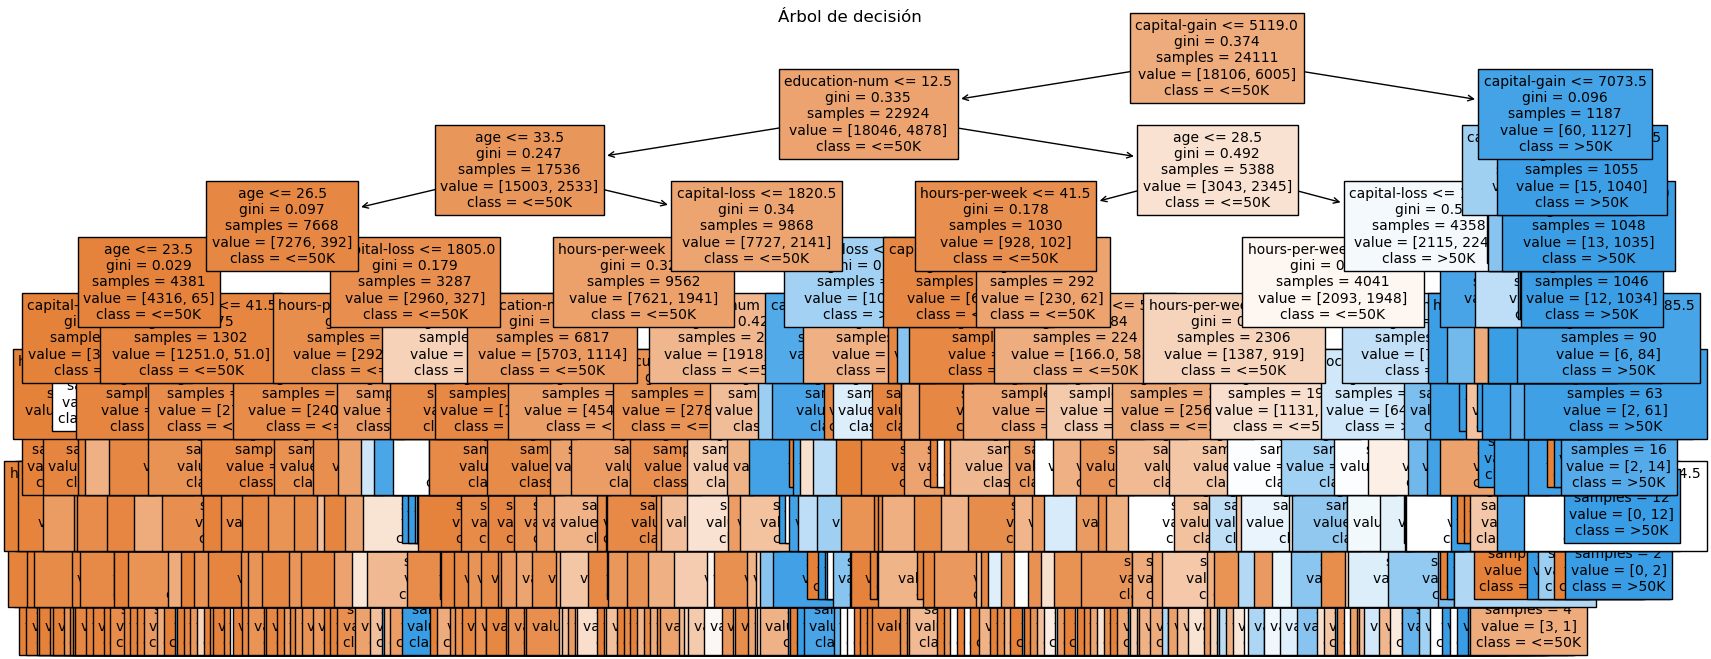

In [32]:
# Visualización del árbol de decisión generado
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
plot_tree(tree, feature_names=X_train.columns, class_names=['<=50K','>50K'], filled=True, fontsize=10)
plt.title('Árbol de decisión')
plt.show()

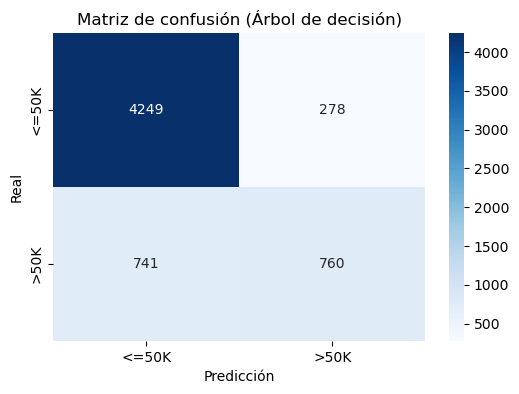

In [33]:
# Matriz de confusión con seaborn
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión (Árbol de decisión)')
plt.show()

### Análisis de los resultados del árbol de decisión

**1. Precisión global (accuracy):**
- El modelo obtuvo una accuracy de **0.83**, lo que significa que el 83% de las predicciones fueron correctas en el conjunto de prueba. Es un valor sólido para este tipo de problema, pero no refleja posibles desbalances entre clases.

**2. Precisión y recall por clase:**
- **Clase 0 (<=50K):**
    - Precisión: 0.85
    - Recall: 0.94
    - F1-score: 0.89
    - El modelo identifica correctamente la mayoría de los casos de ingresos bajos, con pocos falsos negativos.
- **Clase 1 (>50K):**
    - Precisión: 0.73
    - Recall: 0.51
    - F1-score: 0.60
    - El modelo tiene dificultades para identificar los casos de ingresos altos: solo detecta el 51% de los positivos reales y comete más errores al predecir esta clase.

**3. Promedios:**
- Macro avg y weighted avg muestran que el desempeño general es aceptable, pero el recall bajo en la clase positiva (>50K) indica que el modelo tiende a clasificar erróneamente personas con ingresos altos como bajos.

**4. Matriz de confusión:**
- La mayoría de los aciertos se dan en la clase mayoritaria (<=50K).
- Hay una cantidad significativa de falsos negativos (personas con ingresos altos clasificadas como bajos), lo que puede ser crítico si el objetivo es no perder casos positivos.

**5. Interpretación:**
- El modelo es bueno para identificar ingresos bajos, pero tiene dificultades con los ingresos altos.
- El desbalance de clases afecta el recall de la clase positiva (>50K).
- Podria explorarse nuevas variables o transformar las existentes.

**Conclusión:**
El árbol de decisión logra una buena precisión global y clasifica correctamente la mayoría de los casos de ingresos bajos, pero tiene dificultades para identificar ingresos altos. Para aplicaciones donde es crítico detectar correctamente los casos positivos (>50K).

## 6. Clasificador KNN (Q6)

In [34]:
df_one_hot = df_clean.copy()
df_one_hot.drop(columns=['education'], inplace=True)
df_one_hot = pd.get_dummies(df_one_hot, columns=['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], drop_first=True)


In [35]:
df_one_hot_encoded = df_one_hot.copy()
cat_cols = df_one_hot_encoded.select_dtypes(include=['object']).columns
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    df_one_hot_encoded[col] = le.fit_transform(df_one_hot_encoded[col])
    le_dict[col] = le
df_one_hot_encoded.head(1)

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,2174,0,40,0,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [36]:
X_one_hot = df_one_hot_encoded.drop('income', axis=1)
y_one_hot = df_one_hot_encoded['income']
X_train_one_hot, X_test_one_hot, y_train_one_hot, y_test_one_hot = train_test_split(
    X_one_hot, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot
)

print('Forma de X_train_one_hot:', X_train_one_hot.shape)
print('Forma de X_test_one_hot:', X_test_one_hot.shape)
print('Distribución de la variable objetivo en el conjunto de entrenamiento:')
print(y_train_one_hot.value_counts(normalize=True).round(3))
print('Distribución de la variable objetivo en el conjunto de prueba:')
print(y_test_one_hot.value_counts(normalize=True).round(3))

Forma de X_train_one_hot: (24111, 81)
Forma de X_test_one_hot: (6028, 81)
Distribución de la variable objetivo en el conjunto de entrenamiento:
income
0    0.751
1    0.249
Name: proportion, dtype: float64
Distribución de la variable objetivo en el conjunto de prueba:
income
0    0.751
1    0.249
Name: proportion, dtype: float64


In [37]:
best_k = None
best_acc = 0
best_rec = 0
scores = []

for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_one_hot, y_train_one_hot)
    y_pred_knn = knn.predict(X_test_one_hot)
    acc = accuracy_score(y_test_one_hot, y_pred_knn)
    rec = recall_score(y_test_one_hot, y_pred_knn)
    scores.append({'k': k, 'accuracy': acc, 'recall': rec})
    if acc > best_acc:
        best_acc = acc
        best_rec = rec
        best_k = k

print(f"Mejor k según accuracy: {best_k}")
print(f"Accuracy: {best_acc:.4f}, Recall: {best_rec:.4f}")

# Mostrar todos los scores en un DataFrame
scores_df = pd.DataFrame(scores)
print(scores_df.sort_values('accuracy', ascending=False).head())

Mejor k según accuracy: 19
Accuracy: 0.7888, Recall: 0.2219
     k  accuracy    recall
18  19  0.788819  0.221852
17  18  0.788653  0.208528
15  16  0.788653  0.211193
19  20  0.788487  0.203198
16  17  0.787492  0.225183


In [38]:
scores_df.sort_values('accuracy', ascending=False)

,k,accuracy,recall
18,19,0.788819,0.221852
17,18,0.788653,0.208528
15,16,0.788653,0.211193
19,20,0.788487,0.203198
16,17,0.787492,0.225183
13,14,0.786994,0.215856
9,10,0.786662,0.230513
14,15,0.786496,0.231179
11,12,0.785833,0.222518
7,8,0.784837,0.227848


In [39]:
# Entrenamiento y evaluación de KNN con k=19 usando datos one-hot
knn_19 = KNeighborsClassifier(n_neighbors=19)
knn_19.fit(X_train_one_hot, y_train_one_hot)
y_pred_knn_19 = knn_19.predict(X_test_one_hot)
y_pred_modelo_3 = y_pred_knn_19
y_pred_modelo_3_proba = knn_19.predict_proba(X_test_one_hot)

print('Accuracy en test (k=19):', accuracy_score(y_test_one_hot, y_pred_knn_19))
print('\nReporte de clasificación (k=19):')
print(classification_report(y_test_one_hot, y_pred_knn_19))
print('\nMatriz de confusión (k=19):')
print(confusion_matrix(y_test_one_hot, y_pred_knn_19))

Accuracy en test (k=19): 0.7888188453881885

Reporte de clasificación (k=19):
              precision    recall  f1-score   support

           0       0.79      0.98      0.87      4527
           1       0.76      0.22      0.34      1501

    accuracy                           0.79      6028
   macro avg       0.78      0.60      0.61      6028
weighted avg       0.78      0.79      0.74      6028


Matriz de confusión (k=19):
[[4422  105]
 [1168  333]]


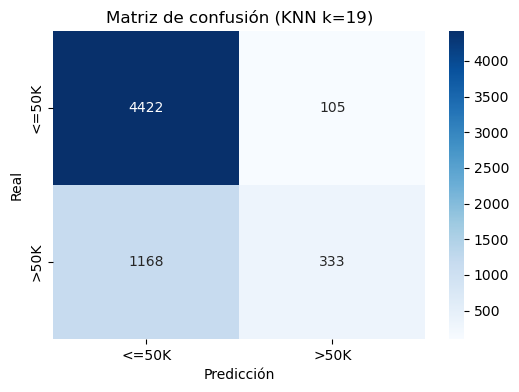

In [40]:
cm_knn_19 = confusion_matrix(y_test_one_hot, y_pred_knn_19)
plt.figure(figsize=(6,4))
sns.heatmap(cm_knn_19, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de confusión (KNN k=19)')
plt.show()

### Análisis de los resultados del clasificador KNN (k=19)

**1. Precisión global (accuracy):**
- El modelo KNN con k=19 obtuvo una accuracy de **0.79**, lo que significa que el 79% de las predicciones fueron correctas en el conjunto de prueba. Es un valor aceptable, aunque ligeramente inferior al obtenido con el árbol de decisión.

**2. Precisión y recall por clase:**
- **Clase 0 (<=50K):**
    - Precisión: 0.79
    - Recall: 0.98
    - F1-score: 0.88
    - El modelo identifica correctamente la mayoría de los casos de ingresos bajos, con muy pocos falsos negativos.
- **Clase 1 (>50K):**
    - Precisión: 0.76
    - Recall: 0.34
    - F1-score: 0.47
    - El modelo tiene dificultades para identificar los casos de ingresos altos: solo detecta el 34% de los positivos reales y comete más errores al predecir esta clase.

**3. Promedios:**
- Macro avg y weighted avg muestran que el desempeño general es moderado, pero el recall bajo en la clase positiva (>50K) indica que el modelo tiende a clasificar erróneamente personas con ingresos altos como bajos.

**4. Matriz de confusión:**
- La mayoría de los aciertos se dan en la clase mayoritaria (<=50K).
- Hay una cantidad significativa de falsos negativos (personas con ingresos altos clasificadas como bajos), lo que puede ser crítico si el objetivo es no perder casos positivos.

**5. Interpretación:**
- El modelo KNN es bueno para identificar ingresos bajos, pero tiene dificultades con los ingresos altos.
- El desbalance de clases afecta el recall de la clase positiva (>50K).
- Podría explorarse el ajuste de k, técnicas de balanceo de clases o el uso de otros modelos para mejorar el recall en la clase positiva.

**Conclusión:**
El clasificador KNN con k=19 logra una precisión global aceptable y clasifica correctamente la mayoría de los casos de ingresos bajos, pero tiene dificultades para identificar ingresos altos.

## 7. Evaluacion algoritmos 

- **Accuracy (Exactitud)**: Es el porcentaje total de predicciones correctas. Si el 90% de las personas en el dataset gana <=50K, un modelo que siempre predice <=50K tendrá un 90% de accuracy, pero será completamente inútil. Es una métrica peligrosa en datasets desbalanceados
- **Precision (Precisión)**: De todos los individuos que el modelo predijo que ganan >50K. Una alta precisión es clave si: El costo de un falso positivo es alto
- **Recall (Sensibilidad)**: De todos los individuos que realmente ganan >50K, ¿cuantos se identificaron correctamente?. Un alto recall es clave si el costo de un falso negativo es alto. Por ejemplo, si se busca identificar a la mayor cantidad posible de clientes potenciales de altos ingresos, incluso si eso significa contactar a algunos que no lo son.
- **F1-Score:** Es la media armónica entre Precision y Recall. Es una métrica excelente para datasets desbalanceados porque busca un equilibrio entre ambas. Un F1-Score alto indica que el modelo es robusto tanto en precisión como en recall.
- **AUC-ROC:** El "Área Bajo la Curva ROC" mide la capacidad del modelo para distinguir entre las dos clases (>50K y <=50K). Un valor de 1.0 es un clasificador perfecto, mientras que 0.5 es un clasificador que adivina al azar. Es muy robusta ante el desbalanceo de clases. 


Resultados para el Modelo 1
              precision    recall  f1-score   support

       <=50K       0.83      0.88      0.86      4527
        >50K       0.56      0.47      0.51      1501

    accuracy                           0.78      6028
   macro avg       0.70      0.67      0.68      6028
weighted avg       0.77      0.78      0.77      6028

AUC Score del Modelo 1: 0.7726


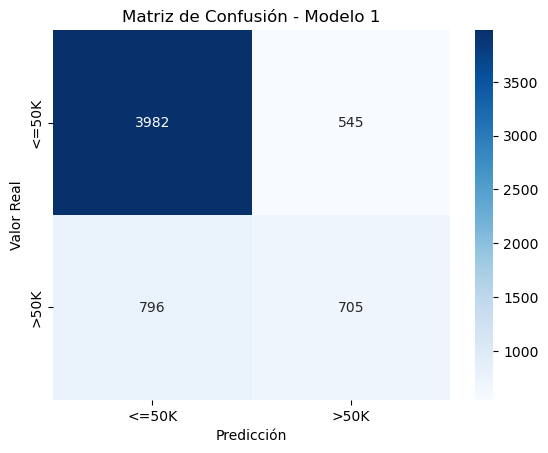

In [48]:
# y_pred_proba_modelo1: probabilidades de predicción para la clase positiva (>50K)
y_pred_modelo_1_num = (y_pred_modelo_1 == '>50K').astype(int)
class_names = ['<=50K', '>50K']
# --- Reporte de Clasificación (Precision, Recall, F1-Score) ---
print("Resultados para el Modelo 1")
# Asumiendo que la clase '>50K' está codificada como 1 
print(classification_report(y_test, y_pred_modelo_1_num, target_names=class_names))
# --- Puntuación AUC-ROC ---
auc_score = roc_auc_score(y_test, y_pred_modelo_1_proba[:,1])
print(f"AUC Score del Modelo 1: {auc_score:.4f}")

cm = confusion_matrix(y_test, y_pred_modelo_1_num)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Modelo 1')
plt.show()

Resultados para el Modelo 2
              precision    recall  f1-score   support

       <=50K       0.75      1.00      0.86      4527
        >50K       0.00      0.00      0.00      1501

    accuracy                           0.75      6028
   macro avg       0.38      0.50      0.43      6028
weighted avg       0.56      0.75      0.64      6028

AUC Score del Modelo 2: 0.8041


/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


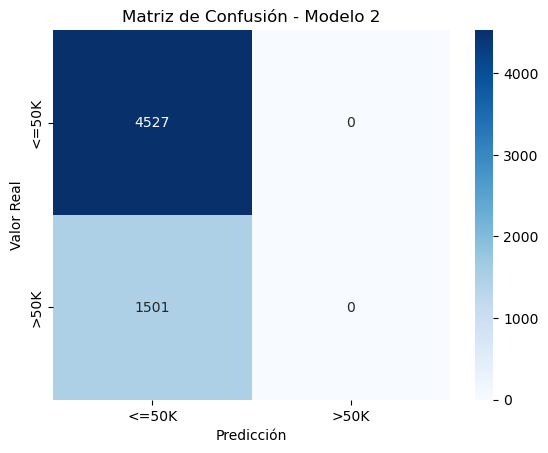

In [49]:
# y_pred_proba_modelo1: probabilidades de predicción para la clase positiva (>50K)
y_pred_modelo_2_num = (y_pred_modelo_2 == '>50K').astype(int)
class_names = ['<=50K', '>50K']
# --- Reporte de Clasificación (Precision, Recall, F1-Score) ---
print("Resultados para el Modelo 2")
# Asumiendo que la clase '>50K' está codificada como 1 
print(classification_report(y_test, y_pred_modelo_2_num, target_names=class_names))
# --- Puntuación AUC-ROC ---
auc_score = roc_auc_score(y_test, y_pred_modelo_2_proba[:,1])
print(f"AUC Score del Modelo 2: {auc_score:.4f}")

# --- Matriz de Confusión Visual ---
cm = confusion_matrix(y_test, y_pred_modelo_2_num)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Modelo 2')
plt.show()

Resultados para el Modelo 3
              precision    recall  f1-score   support

       <=50K       0.75      1.00      0.86      4527
        >50K       0.00      0.00      0.00      1501

    accuracy                           0.75      6028
   macro avg       0.38      0.50      0.43      6028
weighted avg       0.56      0.75      0.64      6028

AUC Score del Modelo 2: 0.6468


/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cristian/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


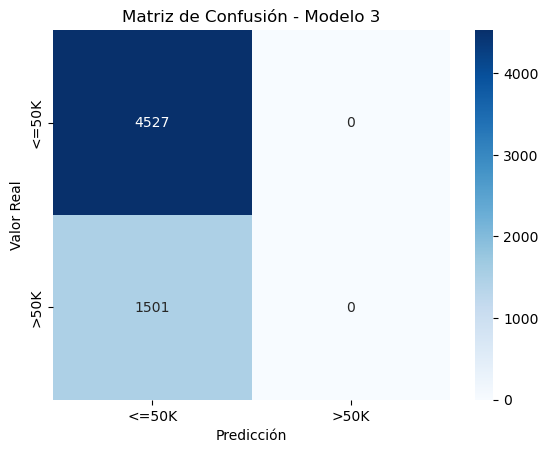

In [51]:
# y_pred_proba_modelo1: probabilidades de predicción para la clase positiva (>50K)
y_pred_modelo_3_num = (y_pred_modelo_3 == '>50K').astype(int)
class_names = ['<=50K', '>50K']
# --- Reporte de Clasificación (Precision, Recall, F1-Score) ---
print("Resultados para el Modelo 3")
print(classification_report(y_test, y_pred_modelo_3_num, target_names=class_names))
# --- Puntuación AUC-ROC ---
auc_score = roc_auc_score(y_test, y_pred_modelo_3_proba[:,1])
print(f"AUC Score del Modelo 2: {auc_score:.4f}")

# --- Matriz de Confusión Visual ---
cm = confusion_matrix(y_test, y_pred_modelo_3_num)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Modelo 3')
plt.show()